# Wafer scale variation analysis

>Author: Jaspreet Jhoja (jaspreetj@ece.ubc.ca)<br>
>Microsystems and Nanotechnology Group (MiNa) Lab<br>
>University of British Columbia<br>
>Special thanks to Zeqin Lu

This notebook provides a utility to extract variation parameters such as mean, sigma and correlation length for width and thickness variations. 

In [50]:
"""
Import dependencies
"""
import random, matplotlib, time, warnings, os, sys
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import interpolate
from scipy.io import loadmat
import scipy.signal as sig
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from glob import glob
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output
from scipy.optimize import curve_fit, differential_evolution
from numpy.linalg import inv


def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return float('.'.join([i, (d+'0'*n)[:n]]))



#running mean function
def windowed_mean(arr, n):
    dims = len(arr.shape)
    s = sig.convolve(arr, np.ones((2*n+1,)*dims), mode='same')
    d = sig.convolve(np.ones_like(arr), np.ones((2*n+1,)*dims), mode='same')
    return s/d




#function to detect peaks
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):
    
    __author__ = "Marcos Duarte, https://github.com/demotu/BMC"
    __version__ = "1.0.5"
    __license__ = "MIT"

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height (if parameter
        `valley` is False) or peaks that are smaller than maximum peak height
         (if parameter `valley` is True).
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=-1.2, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)

    Version history
    ---------------
    '1.0.5':
        The sign of `mph` is inverted if parameter `valley` is True
    
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
            if mph is not None:
                mph = -mph
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


In [2]:
# plot settings
font = {'family' : 'Open Sans',
        'weight': 'regular',
        'size'   : 12}
matplotlib.rc('font', **font)



#### Process spectral data and extract width and thickness variations

The following section of the code reads spectral data for racetrack resonators and extract width and thickness variations.

for more information, refer to: https://www.osapublishing.org/oe/abstract.cfm?uri=oe-25-9-9712

Width variation mean = 6.347831981783539
Width variation standard deviation = 8.097247166263546
Thickness variation mean = -2.0745018470347114
Thickness variation standard deviation = 2.6014805618099612


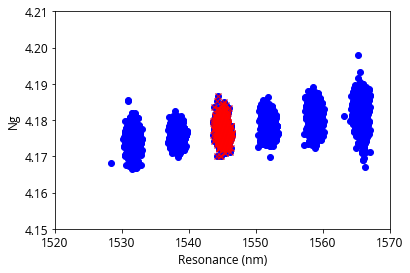

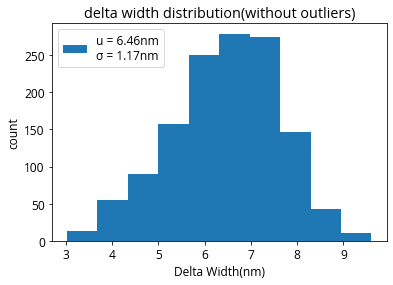

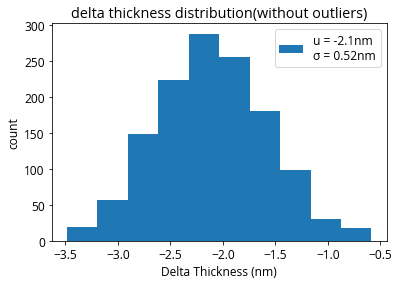

Width variation mean = 6.458740440039498
Width variation standard deviation = 1.1666075090850365
Thickness variation mean = -2.101030156512765
Thickness variation standard deviation = 0.5215062421258978


Width variation mean = 5.455002795473056
Width variation standard deviation = 9.05853058751903
Thickness variation mean = -1.6930776707018955
Thickness variation standard deviation = 2.628872724799576


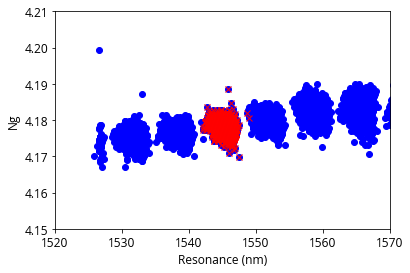

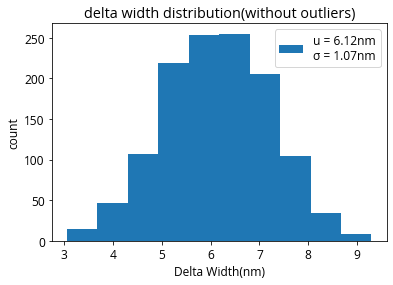

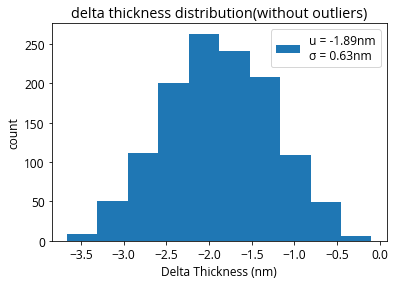

Width variation mean = 6.122815584113899
Width variation standard deviation = 1.0695722803138634
Thickness variation mean = -1.889852681098929
Thickness variation standard deviation = 0.6287392720113741


In [3]:
tot_hx_arr = [] 
tot_hy_arr = []
all_dh = []

tot_wx_arr = []
tot_wy_arr = []
all_dw = []


home_dir = os.getcwd()
#measurements were conducted in two batches, upper and lower sections of the chip
#specify folders containing data
folders = ['top-half', 'bottom-half'] 

for each_dataset in folders:

    dir_path = home_dir+"\measurements\\"+ each_dataset
    prefix = 'badlabel_opt_in_TE_1550_variabilitymrr'

    os.chdir(dir_path)
    file_list = glob(prefix+"*.mat")


    # Part 1, extract resonance peaks and corresponding ng
    #Define a lambda vs ng curve for selected resonance mode

    # Ring resonator structure parameter
    rR = 12 #ring radius in microns
    rLc = 4.5 #coupling length
    dL = ((2 * rLc) + 2*np.pi*rR) * 1e3

    x = [1545, 1546.25]
    y = [4.184, 4.172]

    A = 1/(x[1]-x[0])
    B = -1/(y[1]-y[0])
    C = y[0]/(y[1]-y[0]) - x[0]/(x[1]-x[0])

    resonance_selected = []
    ng_selected = []

    resonance_p_array = []
    ng_p_array = []



    for jj in tqdm_notebook(range(len(file_list)), desc='read and process spectral data', leave=False):
        each_file = file_list[jj]
        #sys.stdout.write("file {}/{}\r".format(jj, len(file_list)))
        #sys.stdout.flush()
        data = loadmat(each_file)
        wavelength = data['scandata']['wavelength'][0][0][0][0:10000]*1e9
        power = data['scandata']['power'][0][0][0:10000]
        #sys.stdout.write("file {}/{} reading file data ........ \r".format(jj, len(file_list)))
        #sys.stdout.flush()
        GC = windowed_mean(power, 60)
        #sys.stdout.write("file {}/{} calculating moving average \r".format(jj, len(file_list)))    
        #sys.stdout.flush()
        power_calibrated = np.subtract(power, GC)
        #sys.stdout.write("file {}/{} calibrating power ........ \r".format(jj, len(file_list)))    
        #sys.stdout.flush()
        power_calibrated = power_calibrated.flatten()
        #sys.stdout.write("\rfile {}/{} flattening moving average".format(jj, len(file_list)))    


        if(0):
            plt.figure()
            plt.xlim(left=1520, right = 1570)
            plt.plot(wavelength,power, 'b')
            plt.plot(wavelength, GC, 'r')
            plt.show()

            plt.figure()
            plt.plot(wavelength, power_calibrated)

        #find peaks
        pks_idx = detect_peaks(-power_calibrated, mpd=550, show=False)
        #sys.stdout.write("file {}/{} finding peaks ........ \r".format(jj, len(file_list)))    
        #sys.stdout.flush()
        resonances = [wavelength[each_idx] for each_idx in pks_idx]


        FSR = np.zeros(len(resonances)-1)
        resonance_partial = np.zeros(len(resonances)-2)

        ng = np.zeros(len(resonances)-2)

        for kk in range(0, len(resonances)-1,1):
            FSR[kk] = resonances[kk+1] - resonances[kk]

        for kk in range(0, len(resonances)-2,1):
            resonance_partial[kk] = resonances[kk+1] #excludes first and last peaks

        for kk in range(0, len(resonance_partial),1):
            ng[kk] = resonance_partial[kk]**2/dL/(FSR[kk]/2+FSR[kk+1]/2)

        #find the resonance of the device
        distance = list(abs(A*resonance_partial+B*ng+C)/np.sqrt(A**2+B**2))

        selected_mode_index = distance.index(min(distance))

        resonance_selected.append(resonance_partial[selected_mode_index])
        ng_selected.append(ng[selected_mode_index])

        [resonance_p_array.append(i) for i in resonance_partial]
        [ng_p_array.append(i) for i in ng]



    #plot resonance and group index

    plt.figure()
    plt.xlim(left=1520, right = 1570)
    plt.ylim(top= 4.21, bottom = 4.15)

    plt.plot(resonance_p_array, ng_p_array, 'bo', linewidth = 1)
    plt.plot(resonance_selected, ng_selected, 'rx', linewidth=2)
    plt.xlabel('Resonance (nm)')
    plt.ylabel('Ng')


    #Part 2: calculate physical variations dw and dh
    #transfer matrix for dw and dh versus d_resonance and d_ng

    A =  -0.001650 #; % dng/dw;  [/nm]
    B = 0.001091#; % dng/dh; [/nm]
    C = 0.585911#; % dlambda/dw; [nm/nm]
    D = 1.36330#; % dlambda/dh; [nm/nm]    
    T = np.array([[A, B], [C, D]])

    lambda_norm = 1544.25012 
    ng_norm = 4.189938

    dw = np.zeros(len(file_list))
    dh = np.zeros(len(file_list))
    delta_ng = np.zeros(len(file_list))
    delta_lambda = np.zeros(len(file_list))

    for ii in tqdm_notebook(range(len(file_list)),desc='Extract width and thickness variations', leave=False):
        delta_ng[ii] = ng_selected[ii] - ng_norm
        delta_lambda[ii] = resonance_selected[ii] - lambda_norm

        inputA = np.array([delta_ng[ii], delta_lambda[ii]])
        outputA = inv(T)*inputA
        outputA = np.sum(outputA, axis=1)
        dw[ii] = outputA[0]
        dh[ii] = outputA[1]



    mu_w = np.mean(dw)
    std_w = np.std(dw)
    print('Width variation mean =', np.mean(dw))
    print('Width variation standard deviation =',np.std(dw))
    mu_h = np.mean(dh)
    std_h = np.std(dh)
    print('Thickness variation mean =', np.mean(dh))
    print('Thickness variation standard deviation =',np.std(dh))


    # Part 3: get GDS xy coordinates for all the ring resonators
             #and associate them with dw and dh values

    filename = 'coordinates.txt'

    x_array = np.zeros(len(file_list))
    y_array = np.zeros(len(file_list))

    with open(filename,'r') as fh:
         for curline in fh:
             if curline.startswith("%"):
                    None
             else:
                lineData = curline.split(',')
                curDevName = lineData[-2]
                if('badlabel_opt_in_TE_1550_variabilitymrr_' in curDevName):
                    index = file_list.index(curDevName+'.mat')
                    x_array[index] = float(lineData[0])
                    y_array[index] = float(lineData[1])


    #remove any outliers in dw/dh data and their corresponding x and y values
    #process data for about 10 cycles to remove outliers

    wx_array = x_array
    wy_array = y_array
    for kk in range(10):
        #print(np.mean(dw), np.std(dw), end='\r', flush=True)
        #get indexes of all the outliers
        outlier_idx = []
        for i in range(len(dw)):
            if(dw[i]< (mu_w - 3*std_w) or dw[i] > (mu_w +3*std_w)):
                outlier_idx.append(i)

        ndw = [dw[i] for i in range(len(dw)) if i not in outlier_idx]
        nx_array = [wx_array[i] for i in range(len(dw)) if i not in outlier_idx]
        ny_array = [wy_array[i] for i in range(len(dw)) if i not in outlier_idx]

        dw = ndw
        wx_array = nx_array
        wy_array = ny_array
        mu_w =  np.mean(dw)
        std_w = np.std(dw)


    #for thickness variations
    hx_array = x_array
    hy_array = y_array
    for kk in range(10):
        #print(np.mean(dh), np.std(dh), end='\r', flush=True)
        #get indexes of all the outliers
        outlier_idx = []
        for i in range(len(dh)):
            if(dh[i]< (mu_h - 3*std_h) or dh[i] > (mu_h +3*std_h)):
                outlier_idx.append(i)

        ndh = [dh[i] for i in range(len(dh)) if i not in outlier_idx]
        nx_array = [hx_array[i] for i in range(len(dh)) if i not in outlier_idx]
        ny_array = [hy_array[i] for i in range(len(dh)) if i not in outlier_idx]

        dh = ndh
        hx_array = nx_array
        hy_array = ny_array
        mu_h = np.mean(dh)
        std_h = np.std(dh)


    #without outliers
    plt.figure()
    plt.hist(dw)
    plt.xlabel('Delta Width(nm)')
    plt.ylabel('count')
    plt.legend(['u = '+str(round(np.mean(dw),2)) +'nm\n'+ 'σ = '+str(round(np.std(dw),2))+'nm'])
    plt.title('delta width distribution(without outliers)')
    #plt.savefig('ANT_deltawidth_distribution(without outliers).pdf')

    plt.figure()
    plt.hist(dh)
    plt.title('delta thickness distribution(without outliers)')
    plt.xlabel('Delta Thickness (nm)')
    plt.ylabel('count')
    plt.legend(['u = '+str(round(np.mean(dh),2)) +'nm\n'+ 'σ = '+str(round(np.std(dh),2))+'nm'])
    #plt.savefig('ANT_deltathickness_distribution(without outliers).pdf')
    plt.show()

    print('Width variation mean =', np.mean(dw))
    print('Width variation standard deviation =',np.std(dw))
    print('Thickness variation mean =', np.mean(dh))
    print('Thickness variation standard deviation =',np.std(dh))

    tot_hx_arr = np.concatenate((tot_hx_arr, hx_array))
    tot_hy_arr = np.concatenate((tot_hy_arr, hy_array))
    all_dh = np.concatenate((all_dh, dh))

    tot_wx_arr = np.concatenate((tot_wx_arr,wx_array))
    tot_wy_arr = np.concatenate((tot_wy_arr, wy_array))
    all_dw = np.concatenate((all_dw, dw))

#### Width and Thickness variations' stats for combined datasets 

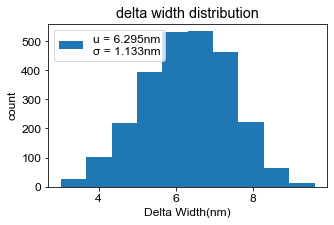

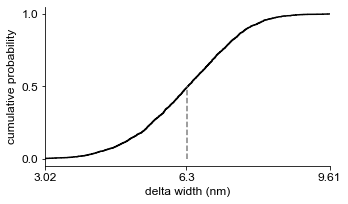

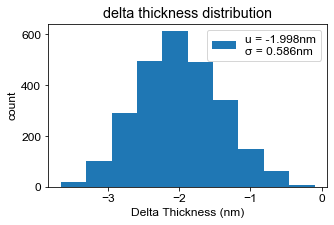

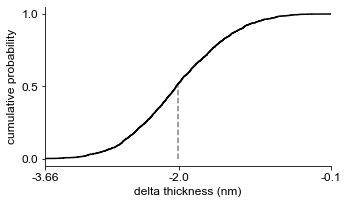

Width variation mean = 6.295359995692206
Width variation standard deviation = 1.1329735447744462
Thickness variation mean = -1.9983218598188963
Thickness variation standard deviation = 0.58574669959745


In [64]:
fig_size = (5,3)

fig = plt.figure()
plt.hist(all_dw)
plt.xlabel('Delta Width(nm)')
plt.ylabel('count')
plt.legend(['u = '+str(round(np.mean(all_dw),3)) +'nm\n'+ 'σ = '+str(round(np.std(all_dw),3))+'nm'])
plt.title('delta width distribution')
fig.set_size_inches(fig_size)
#plt.savefig('ANT_deltawidth_distribution(without outliers).pdf')


fig = plt.figure()
temp_data = all_dw
h, edges = np.histogram(temp_data, density=False, bins=len(temp_data))
h = np.cumsum(h)/np.cumsum(h).max()
X = edges.repeat(2)[:-1]
y = np.zeros_like(X)
y[1:] = h.repeat(2)
plt.plot(X, y, 'k')
plt.plot([round(np.mean(temp_data),2), round(np.mean(temp_data),2)],[0, 0.5], linestyle='--', color= 'grey')
plt.xlim(left =min(temp_data), right= max(temp_data))
plt.xticks([round(min(temp_data),2), np.mean(temp_data), round(max(temp_data),2)], [round(min(temp_data),2), round(np.mean(temp_data),2), round(max(temp_data),2)])
plt.yticks([0, 0.5, 1])
plt.xlabel('delta width (nm)')
plt.ylabel('cumulative probability')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
fig.set_size_inches(fig_size)
plt.tight_layout()
#plt.title('mean = '+str(np.mean(temp_data))[0:5]+' (nm), sigma = '+ str(np.std(temp_data))[0:5]+' (nm)', fontsize = 18)
plt.savefig('./results/cl_exp_2width_mean_sigma.png',dpi = 600)

fig = plt.figure()
plt.hist(all_dh)
plt.title('delta thickness distribution')
plt.xlabel('Delta Thickness (nm)')
plt.ylabel('count')
plt.legend(['u = '+str(round(np.mean(all_dh),3)) +'nm\n'+ 'σ = '+str(round(np.std(all_dh),3))+'nm'])
#plt.savefig('ANT_deltathickness_distribution(without outliers).pdf')
fig.set_size_inches(fig_size)
plt.show()


temp_data = all_dh
fig = plt.figure()
h, edges = np.histogram(temp_data, density=False, bins=len(temp_data))
h = np.cumsum(h)/np.cumsum(h).max()
X = edges.repeat(2)[:-1]
y = np.zeros_like(X)
y[1:] = h.repeat(2)
plt.plot(X, y, 'k')
plt.plot([round(np.mean(temp_data),2), round(np.mean(temp_data),2)],[0, 0.5], linestyle='--', color= 'grey')
plt.xlim(left =min(temp_data), right= max(temp_data))
plt.xticks([round(min(temp_data),2), np.mean(temp_data), round(max(temp_data),2)], [round(min(temp_data),2), round(np.mean(temp_data),2), round(max(temp_data),2)])
plt.yticks([0, 0.5, 1])
plt.xlabel('delta thickness (nm)')
plt.ylabel('cumulative probability')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
fig.set_size_inches(fig_size)
plt.tight_layout()
#print(np.mean(temp_data),np.std(temp_data))
plt.savefig('./results/cl_exp_3thickness_mean_sigma.png', dpi=600)
plt.show()

print('Width variation mean =', np.mean(all_dw))
print('Width variation standard deviation =',np.std(all_dw))
print('Thickness variation mean =', np.mean(all_dh))
print('Thickness variation standard deviation =',np.std(all_dh))





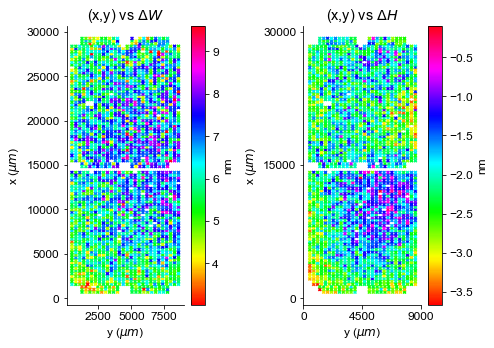

In [67]:


font = {'family' : 'arial',
        'weight': 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

import matplotlib.gridspec as gridspec
#ncols =2, nrows=1, constrained_layout = True)

fig1 = plt.subplots(ncols=2, nrows=1, constrained_layout = True, figsize=(7,5))#figure_params['figsize'])
#spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
plt.subplot(122)
plt.title(r'(x,y) vs $\Delta H$')
plt.scatter( tot_hy_arr, tot_hx_arr,  c = all_dh, s=8.5,  cmap = 'hsv', marker = 'x')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.ylabel(r'x ($\mu m$)')
plt.xlabel(r'y ($\mu m$)')
#plt.ylim(left = 0, right = 30000)
#plt.xlim(top = 9000, bottom = 0)
plt.yticks([0,15000,30000])
plt.xticks([0,4500,9000])
plt.tight_layout()
colorbar = plt.colorbar()
colorbar.set_label('nm')
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.subplot(121)
im= plt.scatter(tot_wy_arr, tot_wx_arr, c = all_dw, s=8.5,  cmap = 'hsv', marker = 'x')
#plt.hexbin(x = tot_wx_arr, y = tot_wy_arr,  C = all_dw,  bins = 'log')
plt.title(r'(x,y) vs $\Delta W$')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.ylabel(r'x ($\mu m$)')
plt.xlabel(r'y ($\mu m$)')
#plt.xlim(left = 0, right = 30000)
#plt.ylim(top = 9000+0, bottom = 0)
#plt.xticks([0, 15000, 30000])
#plt.yticks([0,4500,9000])
plt.tight_layout()
colorbar = plt.colorbar()
colorbar.set_label('nm')
plt.tight_layout()
#plt.rasterize(true)
plt.savefig('./results/variationsvssurface.png', dpi=600)
#plt.savefig('cl_exp_ogpoints_combined.pdf', dpi=600)
plt.show()




#### [Optional] Save processed data to a mat file

In [ ]:

from scipy.io import savemat
mat_dict = {'tot_hx_arr': tot_hx_arr,'tot_hy_arr': tot_hy_arr,'all_dh': all_dh,
            'tot_wx_arr': tot_wx_arr,'tot_wy_arr': tot_wy_arr,'all_dw': all_dw}
savemat('ant_run_data.mat', mat_dict )

#read data from file
from scipy.io import loadmat
load_dict = loadmat('ant_run_data.mat')
tot_wx_arr = load_dict['tot_wx_arr'][0]
tot_wy_arr = load_dict['tot_wy_arr'][0]
all_dw = load_dict['all_dw'][0]

tot_hx_arr = load_dict['tot_hx_arr'][0]
tot_hy_arr = load_dict['tot_hy_arr'][0]
all_dh = load_dict['all_dh'][0]


### Calculate correlation lengths for width variations

First, we calculate H(r) for combination of r, and then sort data in ascending order.
Note: you might have to tweak the tolerance and data range to get better estimations.

In [ ]:
#Calculate CL for thickness variations

#for each pair generate absolute difference between heights
rh_pair = [[], []]
count = 0
for i in tqdm_notebook(range(len(tot_hx_arr)), desc='calculating H(r) - r pairs', leave=False):
    for j in range(i+1,len(tot_hx_arr),1):
        e = np.sqrt((tot_hx_arr[i] - tot_hx_arr[j])**2 + (tot_hy_arr[i] - tot_hy_arr[j])**2)        
        #rh = np.sqrt((all_dh[i] - all_dh[j])**2)
        rh = abs(all_dh[i]**2 - all_dh[j]**2)
    
        rh_pair[0].append(e)
        rh_pair[1].append(rh)
        
bin_size = 1

#generate limits as arrays
ranges = []
for max_limit in range(0, int(max(rh_pair[0])), bin_size):
    ranges.append([max_limit, max_limit+bin_size,  [], []])

avg_h = [[], []]

#n times add them in the appropriate dictionaries
for i in tqdm_notebook(range(len(rh_pair[0])), desc='sorting data in ascending order', leave=False):
    each_val = rh_pair[0][i]
    #binary search to find the best match
    left = 0
    right = len(ranges)-1
    while True:
        arr_idx = int(round((left+right)/2))
        if(each_val >= ranges[arr_idx][0] and each_val < ranges[arr_idx][1]):
            break
            
        else:
            if(each_val < ranges[arr_idx][0]):
                if(arr_idx > 0):
                    right = arr_idx -1
                else:
                    break
            elif(each_val >= ranges[arr_idx][1]):
                if(arr_idx < len(ranges)-1):
                    left = arr_idx + 1
                else:
                    break
                    
    ranges[arr_idx][2].append(rh_pair[1][i])
    ranges[arr_idx][3].append(rh_pair[0][i])

    
for i in range(len(ranges)):
        if(len(ranges[i][2])>0):
            avg_h[0].append(np.mean(ranges[i][3]))
            avg_h[1].append(np.mean(ranges[i][2]))
        



Consider tweaking data range considered for the fit for better estimations.

In [51]:
def ModelAndScatterPlot(xData, yData, xscale, yscale, graphWidth=800, graphHeight=600, plot='y'):


    # create data for the fitted equation plot
    xModel = np.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)
    
    ydiff = np.diff(yModel)/np.diff(xModel)
    if(np.argmin(ydiff>=0.025)>0): #TOLERANCE
        fit = 1
    else:
        fit = 0
    if(plot=='y'):
        f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=300)
        axes = f.add_subplot(111)        
        f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=300)
        axes = f.add_subplot(111)
        # first the raw data as a scatter plot
        axes.plot((xData*(xscale[1]-xscale[0])) + xscale[0], (yData*(yscale[1]-yscale[0])) + yscale[0],  'D')    
        # now the model as a line plot
        axes.plot((xModel*(xscale[1]-xscale[0])) + xscale[0], (yModel*(yscale[1]-yscale[0])) + yscale[0])
        ##axes.plot((xModel[1:]*(xscale[1]-xscale[0])) + xscale[0], ydiff)
        axes.set_xlabel('X Data') # X axis data label
        axes.set_ylabel('Y Data') # Y axis data label
        plt.show()
        plt.close('all') # clean up after using pyplot
    
    return (xModel*(xscale[1]-xscale[0])) + xscale[0], (yModel*(yscale[1]-yscale[0])) + yscale[0], fit


def func(x, a, b, Offset): # Sigmoid A With Offset
    return  1.0 / (1.0 + np.exp(-a * (x-b))) + Offset


def generate_Initial_Parameters(xData, yData):
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    parameterBounds.append([minX, maxX]) # seach bounds for a
    parameterBounds.append([minX, maxX]) # seach bounds for b
    parameterBounds.append([minX, maxY]) # seach bounds for Offset

    # function for genetic algorithm to minimize (sum of squared error)
    def sumOfSquaredError(parameterTuple):
        warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
        val = func(xData, *parameterTuple)
        return np.sum((yData - val) ** 2.0)
    # "seed" the np random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x



rsquared_arr = []
div_arr = []


for div in tqdm_notebook(range(1,40,1), desc='calculating fit', leave=False): #DATA RANGE
    divisor = div/10
    xData = np.array(avg_h[0][0:int(len(avg_h[0])/divisor)], dtype='float')
    max_x = max(xData)
    min_x = min(xData)
    xData = (xData - min_x)/(max_x - min_x)

    yData = np.array(avg_h[1][0:int(len(avg_h[0])/divisor)], dtype='float')
    max_y = max(yData)
    min_y = min(yData)
    yData = (yData - min_y)/(max_y - min_y)

    # generate initial parameter values
    geneticParameters = generate_Initial_Parameters(xData, yData)

    # curve fit the test data
    fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

    #print('Parameters', fittedParameters)

    modelPredictions = func(xData, *fittedParameters) 

    absError = modelPredictions - yData

    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(yData))
    xfit, yfit, tempfit = ModelAndScatterPlot(xData, yData, [min_x, max_x], [min_y, max_y], plot= 'n')
    if(tempfit ==1):
        rsquared_arr.append(Rsquared)
        div_arr.append(div)
        #print('RMSE:', RMSE)
        #print('R-squared:', Rsquared)
    #print()
    #xfit, yfit = ModelAndScatterPlot(xData, yData, scalex, scaley, graphWidth, graphHeight)

#idx = len(rsquared_arr)-1#rsquared_arr.index(max(rsquared_arr))
div = div_arr[-1]
divisor = div/10
xData = np.array(avg_h[0][0:int(len(avg_h[0])/divisor)], dtype='float')#np.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
#normalize
max_x = max(xData)
min_x = min(xData)

xData = (xData - min_x)/(max_x - min_x)

yData = np.array(avg_h[1][0:int(len(avg_h[0])/divisor)], dtype='float')#np.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
max_y = max(yData)
min_y = min(yData)
#scaley = max(yData)
yData = (yData - min_y)/(max_y - min_y)


# generate initial parameter values
geneticParameters = generate_Initial_Parameters(xData, yData)

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)
print('DIV', div)
rsquared_arr.append(Rsquared)
div_arr.append(div)
#xofit, yofit, fit = ModelAndScatterPlot(xData, yData, [min_x, max_x], [min_y, max_y], graphWidth, graphHeight, 'n')


xfit = (xData*(max_x - min_x)) + min_x
yfit = (modelPredictions*(max_y - min_y)) + min_y

func = interpolate.interp1d(xfit, yfit)
xnew = np.linspace(min(xfit), max(xfit), max(xfit)+1)
ynew = func(xnew)
#plt.plot(xnew, ynew,'b')

#print(xnew[maxz_idx])
print('')
print(0.85, '=',xnew[np.argmax(ynew >= 0.85 * max(ynew))],', ', end='')
print(0.9, '=',xnew[np.argmax(ynew >= 0.9 * max(ynew))],', ', end='')
print(0.925, '=', xnew[np.argmax(ynew >= 0.925 * max(ynew))], ', ', end='')
print(0.95, '=',  xnew[np.argmax(ynew >= 0.95 * max(ynew))], ', ', end= '')
print(0.975, '=', xnew[np.argmax(ynew >= 0.975 * max(ynew))], ', ', end='')
print(0.99, '=', xnew[np.argmax(ynew >= 0.99 * max(ynew))], ', ', end='')
print(1, '=', xnew[np.argmax(ynew >= 1 * max(ynew))], ', ', end='')


Parameters [ 3.13292756 -0.58089573 -0.67687369]
RMSE: 0.10330764512851782
R-squared: 0.07349544927966589
DIV 17

0.85 = 4599.7510273522485 , 0.9 = 6238.172614359482 , 0.925 = 7320.981139265579 , 0.95 = 8722.262759732293 , 0.975 = 10727.173385938515 , 0.99 = 12545.899740893914 , 1 = 14344.047834290011 , 

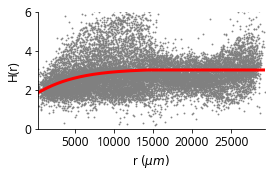

In [24]:
os.chdir(home_dir)
#plot width CL extraction graph
fig, ax = plt.subplots(nrows=1)
ax.scatter(avg_h[0], avg_h[1], marker='.', color='grey', alpha = .9, s=3)
ax.plot(np.concatenate((xfit,[max(avg_h[0])])), np.concatenate((yfit, [max(yfit)])), label='fit', color='r', linewidth=3)
#plt.title('Correlation length extraction for $\Delta H$')
fig.set_size_inches(1.5*2.625, 2.625)
ax.set_ylim(top=6, bottom = 0)
ax.set_xlim(right=max(avg_h[0]), left=min(avg_h[0]))
ax.set_xlabel(r'r $(\mu m)$ ')
ax.set_ylabel('H(r)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_rasterized(True)
plt.tight_layout()
plt.savefig('./results/cl_exp_7thickness.png', dpi=300)
plt.show()



### Calculate correlation lengths for thickness variations

First, we calculate H(r) for combination of r, and then sort data in ascending order.
Note: you might have to tweak the tolerance and data range to get better estimations.

In [25]:
#for each pair generate absolute difference between heights
from tqdm import tqdm_notebook, tqdm
rw_pair = [[], []]
count = 0
for i in tqdm_notebook(range(len(tot_wx_arr))):
    for j in range(i+1,len(tot_wx_arr),1):
        e = np.sqrt((tot_wx_arr[i] - tot_wx_arr[j])**2 + (tot_wy_arr[i] - tot_wy_arr[j])**2)        
        #rh = np.sqrt((all_dh[i] - all_dh[j])**2)
        rw = abs(all_dw[i]**2 - all_dw[j]**2)
    
        rw_pair[0].append(e)
        rw_pair[1].append(rw)
        
bin_size = 1

#generate limits as arrays
ranges = []
for max_limit in range(0, int(max(rw_pair[0])), bin_size):
    ranges.append([max_limit, max_limit+bin_size,  [], []])

avg_w = [[], []]



#n times add them in the appropriate dictionaries
for i in tqdm_notebook(range(len(rw_pair[0]))):
    each_val = rw_pair[0][i]
    #binary search to find the best match
    left = 0
    right = len(ranges)-1
    while True:
        arr_idx = int(round((left+right)/2))
        if(each_val >= ranges[arr_idx][0] and each_val < ranges[arr_idx][1]):
            break
            
        else:
            if(each_val < ranges[arr_idx][0]):
                if(arr_idx > 0):
                    right = arr_idx -1
                else:
                    break
            elif(each_val >= ranges[arr_idx][1]):
                if(arr_idx < len(ranges)-1):
                    left = arr_idx + 1
                else:
                    break
                    
    ranges[arr_idx][2].append(rw_pair[1][i])
    ranges[arr_idx][3].append(rw_pair[0][i])

    
for i in range(len(ranges)):
        if(len(ranges[i][2])>0):
            avg_w[0].append(np.mean(ranges[i][3]))
            avg_w[1].append(np.mean(ranges[i][2]))




Consider tweaking data range considered for the fit for better estimations.

In [53]:
def ModelAndScatterPlot(xData, yData, xscale, yscale, graphWidth=800, graphHeight=600, plot='y'):


    # create data for the fitted equation plot
    xModel = np.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)
    
    ydiff = np.diff(yModel)/np.diff(xModel)
    if(np.argmin(ydiff>=0.025)>0): #TOLERANCE
        fit = 1
    else:
        fit = 0
    if(plot=='y'):
        f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=300)
        axes = f.add_subplot(111)        
        f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=300)
        axes = f.add_subplot(111)
        # first the raw data as a scatter plot
        axes.plot((xData*(xscale[1]-xscale[0])) + xscale[0], (yData*(yscale[1]-yscale[0])) + yscale[0],  'D')    
        # now the model as a line plot
        axes.plot((xModel*(xscale[1]-xscale[0])) + xscale[0], (yModel*(yscale[1]-yscale[0])) + yscale[0])
        ##axes.plot((xModel[1:]*(xscale[1]-xscale[0])) + xscale[0], ydiff)
        axes.set_xlabel('X Data') # X axis data label
        axes.set_ylabel('Y Data') # Y axis data label
        plt.show()
        plt.close('all') # clean up after using pyplot
    
    return (xModel*(xscale[1]-xscale[0])) + xscale[0], (yModel*(yscale[1]-yscale[0])) + yscale[0], fit


def func(x, a, b, Offset): # Sigmoid A With Offset
    return  1.0 / (1.0 + np.exp(-a * (x-b))) + Offset


def generate_Initial_Parameters(xData, yData):
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    parameterBounds.append([minX, maxX]) # seach bounds for a
    parameterBounds.append([minX, maxX]) # seach bounds for b
    parameterBounds.append([minX, maxY]) # seach bounds for Offset

    # function for genetic algorithm to minimize (sum of squared error)
    def sumOfSquaredError(parameterTuple):
        warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
        val = func(xData, *parameterTuple)
        return np.sum((yData - val) ** 2.0)
    # "seed" the np random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x


graphWidth = 800
graphHeight = 600


rsquared_arr = []
div_arr = []


for div in tqdm_notebook(range(1,40,1)): #RANGE
    divisor = div/10
    xData = np.array(avg_w[0][0:int(len(avg_w[0])/divisor)], dtype='float')#np.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
    max_x = max(xData)
    min_x = min(xData)
    xData = (xData - min_x)/(max_x - min_x)

    yData = np.array(avg_w[1][0:int(len(avg_w[0])/divisor)], dtype='float')#np.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
    max_y = max(yData)
    min_y = min(yData)
    yData = (yData - min_y)/(max_y - min_y)

    # generate initial parameter values
    geneticParameters = generate_Initial_Parameters(xData, yData)

    # curve fit the test data
    fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

    #print('Parameters', fittedParameters)

    modelPredictions = func(xData, *fittedParameters) 

    absError = modelPredictions - yData

    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(yData))
    xfit, yfit, tempfit = ModelAndScatterPlot(xData, yData, [min_x, max_x], [min_y, max_y], graphWidth, graphHeight, 'n')
    if(tempfit ==1):
        rsquared_arr.append(Rsquared)
        div_arr.append(div)
        #print('RMSE:', RMSE)
        #print('R-squared:', Rsquared)
    #print()
    #xfit, yfit = ModelAndScatterPlot(xData, yData, scalex, scaley, graphWidth, graphHeight)

#idx = len(rsquared_arr)-1#rsquared_arr.index(max(rsquared_arr))
div = div_arr[-1]
divisor = div/10
xData = np.array(avg_w[0][0:int(len(avg_w[0])/divisor)], dtype='float')#np.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
#normalize
max_x = max(xData)
min_x = min(xData)

xData = (xData - min_x)/(max_x - min_x)

yData = np.array(avg_w[1][0:int(len(avg_w[0])/divisor)], dtype='float')#np.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])
max_y = max(yData)
min_y = min(yData)
#scaley = max(yData)
yData = (yData - min_y)/(max_y - min_y)


# generate initial parameter values
geneticParameters = generate_Initial_Parameters(xData, yData)

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)
print('DIV', div)
rsquared_arr.append(Rsquared)
div_arr.append(div)
#xofit, yofit, fit = ModelAndScatterPlot(xData, yData, [min_x, max_x], [min_y, max_y], graphWidth, graphHeight)


xfit = (xData*(max_x - min_x)) + min_x
yfit = (modelPredictions*(max_y - min_y)) + min_y

func = interpolate.interp1d(xfit, yfit)
xnew = np.linspace(min(xfit), max(xfit), max(xfit)+1)
ynew = func(xnew)


print('')
print(0.9, '=',xnew[np.argmax(ynew > 0.9 * max(ynew))],', ', end='')
print(0.925, '=', xnew[np.argmax(ynew > 0.925 * max(ynew))], ', ', end='')
print(0.95, '=',  xnew[np.argmax(ynew > 0.95 * max(ynew))], ', ', end= '')
print(0.975, '=', xnew[np.argmax(ynew > 0.975 * max(ynew))], ', ')
print(0.99, '=', xnew[np.argmax(ynew >= 0.99 * max(ynew))], ', ')
print(1, '=', xnew[np.argmax(ynew >= 1 * max(ynew))], ', ')

Parameters [ 3.39598399 -0.54133374 -0.69622552]
RMSE: 0.06980178690208026
R-squared: 0.15627623063792961
DIV 13

0.9 = 8831.903041429743 , 0.925 = 10302.86211734535 , 0.95 = 12226.348147580842 , 0.975 = 15035.170136376797 , 
0.99 = 17672.445959482866 , 
1 = 20417.184610521104 , 


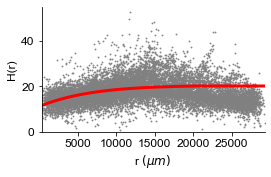

In [54]:
#plot width CL extraction graph

font = {'family' : 'arial',
        'weight': 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(nrows=1)
ax.scatter(avg_w[0], avg_w[1], marker='.', color='grey', alpha = 0.9, s=3)
ax.plot(np.concatenate((xfit,[max(avg_w[0])])), np.concatenate((yfit, [max(yfit)])), label='fit', color='r', linewidth=3)
#plt.title('Correlation length extraction for $\Delta H$')
fig.set_size_inches(1.5*2.625, 2.625)
ax.set_ylim(top=55, bottom = 0)
ax.set_xlim(right=max(avg_w[0]), left=min(avg_w[0]))
ax.set_xlabel(r'r $(\mu m)$ ')
ax.set_ylabel('H(r)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_rasterized(True)
plt.tight_layout()
plt.savefig('./results/cl_exp_6width.png', dpi=300)
plt.show()

